In [ ]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [ ]:
def find_pattern_ZeroMeanCorr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_zmc = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height - 1):
        for x in range(0, im_width - template_width - 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width]
            template = template - np.mean(template)
            zmc = np.sum(regionOfInterest * template)
            if zmc >= max_zmc:
                max_zmc = zmc
                x_max = x
                y_max = y
    return x_max, y_max

def find_pattern_SumSquaredDist(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    least_ssd = math.inf
    x_min = -1
    y_min = -1
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            roi = im[y:y + template_height, x:x + template_width]
            ssd = np.sum((template - roi) **2)
            if ssd < least_ssd:
                least_ssd = ssd
                x_min = x
                y_min = y
    print(least_ssd)
    return x_min, y_min

def find_pattern_NormCrossCorr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_ncc = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width] - np.mean(im[y:y + template_height, x:x + template_width])
            template = template - np.mean(template)
            ncc = np.sum(regionOfInterest * template) / np.sqrt(np.sum(regionOfInterest ** 2) * np.sum(template ** 2))
            if ncc >= max_ncc:
                max_ncc = ncc
                x_max = x
                y_max = y
    return x_max, y_max

def find_pattern_Corr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_corr = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width]
            corr = np.sum(regionOfInterest * template)
            if corr >= max_corr:
                max_corr = corr
                x_max = x
                y_max = y
    return x_max, y_max

def rgb2gray_numpy(rgb_img):
    return np.dot(rgb_img[...,:3], [0.2989, 0.5870, 0.1140])

def test(input_image, template):
    window_size = template.shape
    y = np.lib.stride_tricks.as_strided(input_image,
                    shape=(input_image.shape[0] - window_size[0] + 1,
                           input_image.shape[1] - window_size[1] + 1,) +
                          window_size,
                    strides=input_image.strides * 2)
    ssd = np.einsum('ijkl,kl->ij', y, template)
    ssd *= - 2
    ssd += np.einsum('ijkl, ijkl->ij', y, y)
    ssd += np.einsum('ij, ij', template, template)

    return np.unravel_index(np.argmin(ssd), ssd.shape)


def homoMatrix(src, dst):
        nbp = src.shape[0]
        A = np.zeros((nbp*2, 8))
        B = np.zeros((nbp*2, 1))
        for i in range(src.shape[0]):
            xs, ys = src[i]
            xd, yd = dst[i]
            A[i * 2] = [xs, ys, 1, 0, 0, 0, (-xd)*xs, (-xd)*ys]
            A[i * 2 + 1] = [0, 0, 0, xs, ys, 1, (-yd)*xs, (-yd)*ys]
            B[i * 2] = xd
            B[i * 2 + 1] = yd
        h = np.linalg.lstsq(A, B, rcond=None)[0]
        h = np.append(h, 1)
        h = h.reshape((3, 3))
        return h

def warpDestToSrc(imgSrc, imgDst, src, dst, use_bbox = True):
    h = homoMatrix(src, dst)
    res = imgDst.copy()
    h_inv = np.linalg.inv(h)

    if(use_bbox):
        min_x = np.min(dst[:, 0])
        max_x = np.max(dst[:, 0])
        min_y = np.min(dst[:, 1])
        max_y = np.max(dst[:, 1])
    else:
        min_x = 0
        max_x = imgDst.shape[1]
        min_y = 0
        max_y = imgDst.shape[0]
    
    min = (min_x, min_y)
    max = (max_x, max_y)

    for y in range(min[1], max[1]):
        for x in range(min[0], max[0]):
            p = np.array([x, y, 1])
            p = np.dot(h_inv, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgSrc.shape[1] and p[1] >= 0 and p[1] < imgSrc.shape[0]:
                res[y, x] = imgSrc[int(p[1]), int(p[0])]
                #upscale factor
    return res
    

def warpSrcToDest(imgSrc, imgDst, src, dst):
    h = homoMatrix(src, dst)
    res = imgDst.copy()
    for y in range(imgSrc.shape[0]):
        for x in range(imgSrc.shape[1]):
            # found the corresponding point in the destination image
            p = np.array([x, y, 1])
            p = np.dot(h, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgDst.shape[1] and p[1] >= 0 and p[1] < imgDst.shape[0]:
                cx = int(p[0])
                cy = int(p[1])
                res[cy, cx] = imgSrc[y, x]
    return res
    

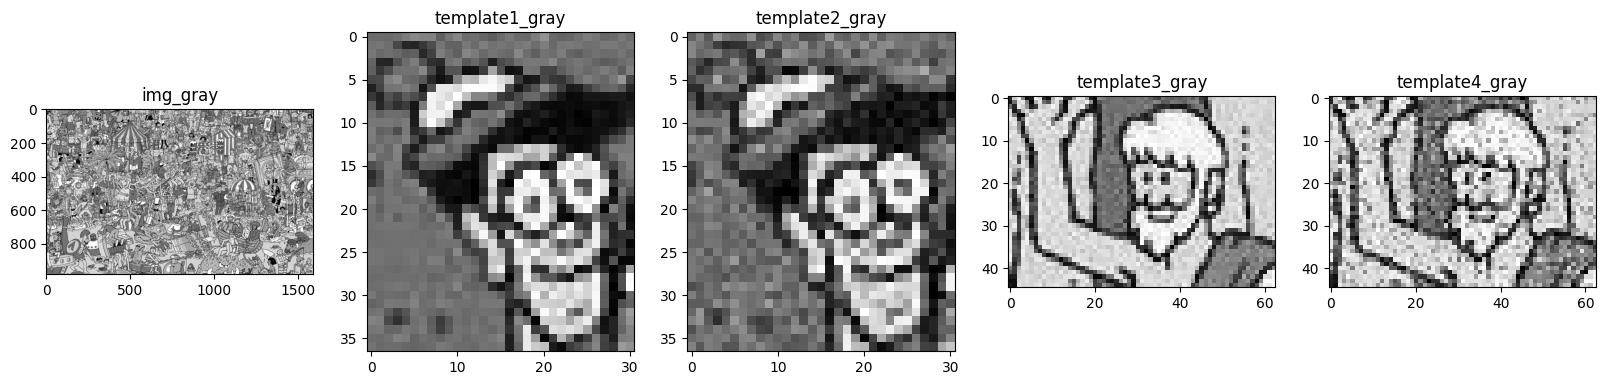

In [32]:
# Variables globales
# read it to a numpy array
img = image.imread('data/where_is_waldo.jpg')
template1 = image.imread('data/template1.png')
template2 = image.imread('data/template2.png')
template3 = image.imread('data/template3.jpg')
template4 = image.imread('data/template4.jpg')

img_gray = rgb2gray_numpy(img)
template1_gray = rgb2gray_numpy(template1)
template2_gray = rgb2gray_numpy(template2)
template3_gray = rgb2gray_numpy(template3)
template4_gray = rgb2gray_numpy(template4)

# show img gray, and all templates
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(img_gray, cmap='gray')
ax.set_title('img_gray')
ax = fig.add_subplot(1, 5, 2)
ax.imshow(template1_gray, cmap='gray')
ax.set_title('template1_gray')
ax = fig.add_subplot(1, 5, 3)
ax.imshow(template2_gray, cmap='gray')
ax.set_title('template2_gray')
ax = fig.add_subplot(1, 5, 4)
ax.imshow(template3_gray, cmap='gray')
ax.set_title('template3_gray')
ax = fig.add_subplot(1, 5, 5)
ax.imshow(template4_gray, cmap='gray')
ax.set_title('template4_gray')



plt.show()


def test_metric(im, templates, func) :
    fig = plt.figure(figsize=(20, 20))
    id = 1
    for i in templates:
        x, y = func(im, i)
        res = im.copy()
        cv.line(res, (x, y), (x + i.shape[1], y), (0, 0, 255), 5)
        cv.line(res, (x, y), (x, y + i.shape[0]), (0, 0, 255), 5)
        cv.line(res, (x + i.shape[1], y), (x + i.shape[1], y + i.shape[0]), (0, 0, 255), 5)
        cv.line(res, (x, y + i.shape[0]), (x + i.shape[1], y + i.shape[0]), (0, 0, 255), 5)
        ax = fig.add_subplot(1, len(templates), id)
        ax.imshow(res, cmap='gray')
        ax.set_title('x: ' + str(x) + ' y: ' + str(y))
        id += 1
    plt.show()

# https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html


# Pattern matching

## What did we do 

We used the waldo dataset to find waldo in a picture, for this we used the following steps:
- iterate over the image
- for each pixel, get a region of interest (ROI) of waldo template size
- compute the corresponding metric between the ROI and the template and store it
- return the location of the ROI with the lowest metric

At first, we tried the sum of squared distances, but it didn't work as you can see in the following images, that's what we tried multiple metrics, see below.

### Sum of squared distances

2778423.607393115
2778298.0159594556
81761.20912441997
2255773.7277805395


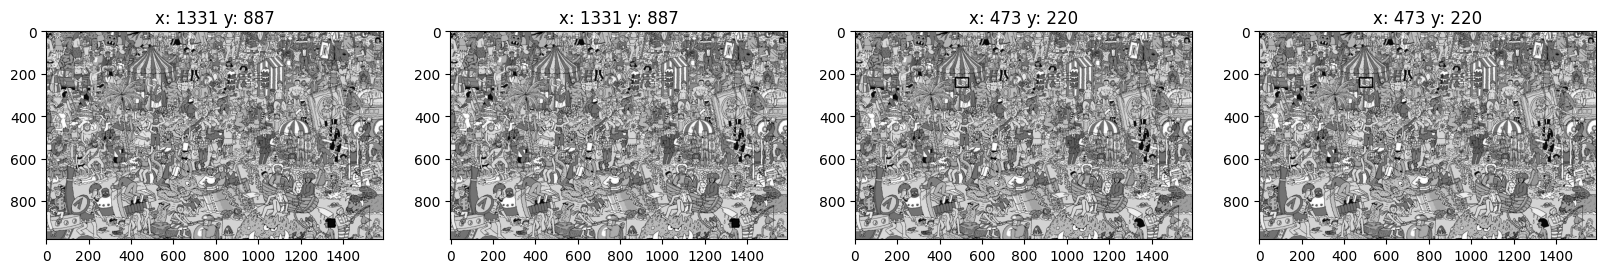

In [33]:
# time correlation
templates = [template1_gray, template2_gray, template3_gray, template4_gray]
test_metric(img_gray, templates, find_pattern_SumSquaredDist)

- It can't find waldo, it's too sensitive to the background / and noise that we may find in the image

### Normalized cross correlation

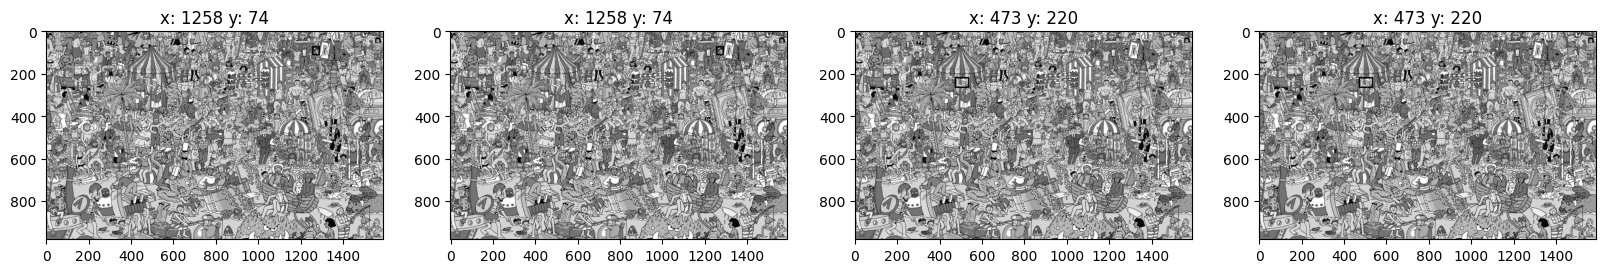

In [34]:
test_metric(img_gray, templates, find_pattern_NormCrossCorr)

- It's able to find waldo, with and without noises so it's a good metric to use but it's painfully slow

### Correlation

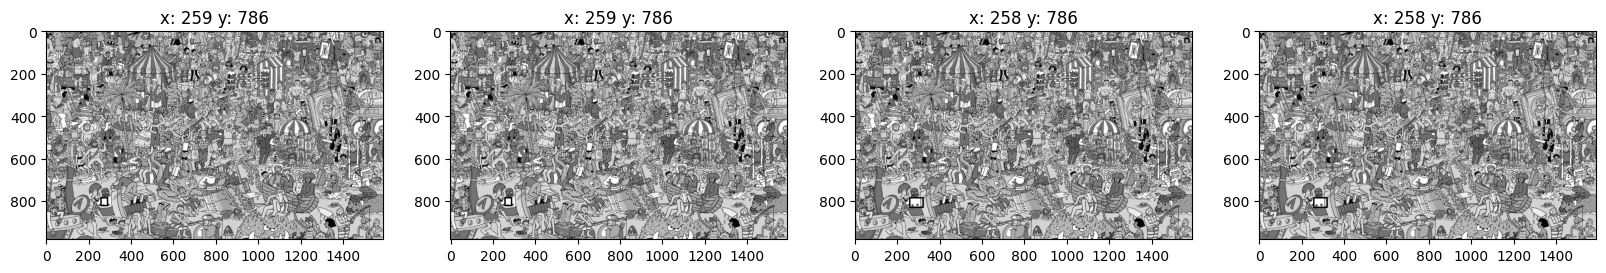

In [35]:
test_metric(img_gray, templates, find_pattern_Corr)

- It's not able to find waldo, it's too sensitive to the background / and noise that we may find in the image but it's faster than the normalized cross correlation
- (real comparaison of timing will be done in the next section)

### Zero mean cross correlation

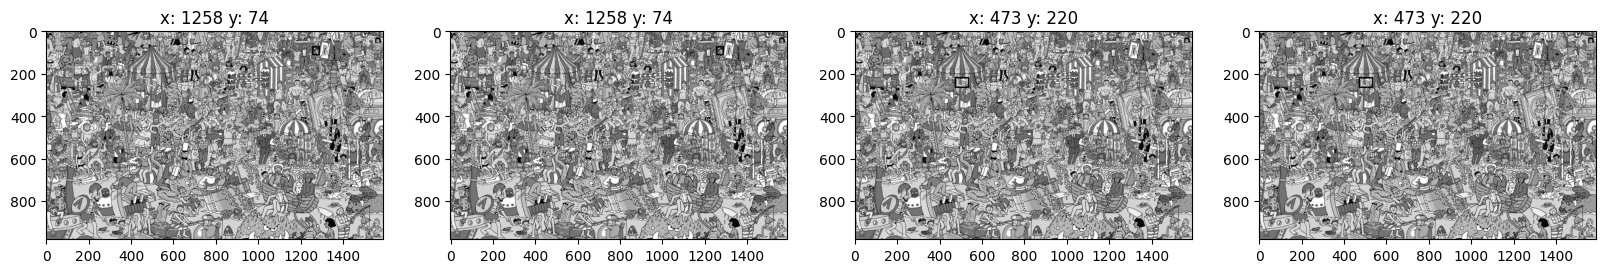

In [36]:
test_metric(img_gray, templates, find_pattern_ZeroMeanCorr)

- It's able to find waldo, with and without noises so it's a good metric to use and it's faster than the normalized cross correlation

## Benchmark

In [37]:
DO_BENCHMARK = 0 #Mettre a 0 pour éviter de run les benchmarks a chaque fois qu'on "run all" les cellules

if (DO_BENCHMARK):
    #functionsToBenchmark = [find_pattern_Corr, find_pattern_ZeroMeanCorr, find_pattern_NormCrossCorr, find_pattern_SumSquaredDist]
    functionsToBenchmark = {"find_pattern_Corr" : find_pattern_Corr, "find_pattern_ZeroMeanCorr": find_pattern_ZeroMeanCorr, "find_pattern_NormCrossCorr" : find_pattern_NormCrossCorr, "find_pattern_SumSquaredDist": find_pattern_SumSquaredDist}

    ITERATIONS = 10

    print("-----------------------")
    print("------ Grayscale ------")
    print("-----------------------")
    for functionName in functionsToBenchmark:
        function = functionsToBenchmark[functionName]

        print("Time for " + functionName + ": ", end='')
        print(timeit.timeit(lambda: function(img_gray, template1_gray), number=ITERATIONS) / ITERATIONS, end='')
        print("s per iteration")





    print()
    print()
    print("-----------------------")
    print("--------- RGB ---------")
    print("-----------------------")
    for functionName in functionsToBenchmark:
        function = functionsToBenchmark[functionName]

        print("Time for " + functionName + ": ", end='')
        print(timeit.timeit(lambda: function(img, template1), number=ITERATIONS) / ITERATIONS, end='')
        print("s per iteration")

# Image transformation

In [38]:
bus = image.imread('data/bus.jpg')

dstlt = (583, 209)
dstrt = (797, 229)
dstbl = (594, 517)
dstbr = (808, 466)

# dstlt = (1229, 1264)
# dstrt = (1940, 1274)
# dstbl = (1274, 2344)
# dstbr = (1983, 2289)

dst = np.array([dstlt, dstrt, dstbl, dstbr])

poster = image.imread('data/ryan.jpg')

srclt = (0, 0)
srctr = (poster.shape[1], 0)
srcbl = (0, poster.shape[0])
srcbr = (poster.shape[1], poster.shape[0])

src = np.array([srclt, srctr, srcbl, srcbr])

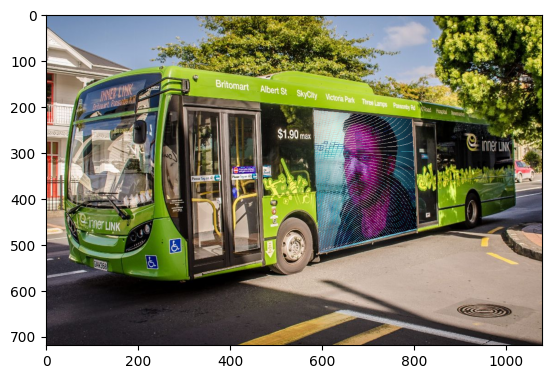

In [39]:
res = warpSrcToDest(poster, bus, src, dst)

plt.imshow(res)
plt.show()

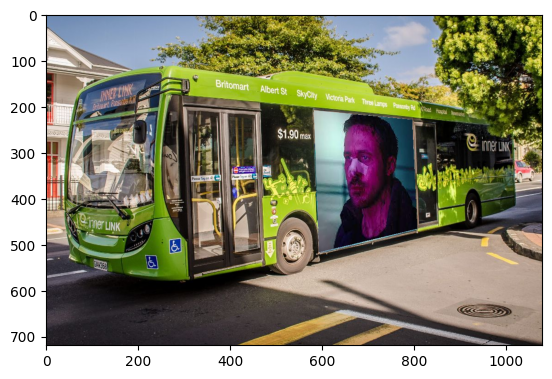

In [40]:
res = warpDestToSrc(poster, bus, src, dst, True)

plt.imshow(res)
plt.show()

In [41]:
def warpSrcToDestNumpy(imgSrc, imgDst, src, dst):
    h = homoMatrix(src, dst)
    coords = np.indices((imgSrc.shape[0], imgSrc.shape[1]))
    coords_homogeneous = np.stack((coords, np.ones(imgSrc.shape[0], imgSrc.shape[1])), axis=2)

    transformed = np.dot(h, coords)
    transformed = transformed / transformed[:]
    
    transformed_x = transformed[]

    res = imgDst.copy()
    correct_pixels = transformed[0]
    
    for y in range(imgSrc.shape[0]):
        for x in range(imgSrc.shape[1]):
            # found the corresponding point in the destination image
            p = np.array([x, y, 1])
            p = np.dot(h, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgDst.shape[1] and p[1] >= 0 and p[1] < imgDst.shape[0]:
                cx = int(p[0])
                cy = int(p[1])
                res[cy, cx] = imgSrc[y, x]
                
    return res

SyntaxError: invalid syntax (2955920621.py, line 9)

# Image Stitching

In [ ]:
def extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2):
    mp_src = []
    mp_dst = []
    for i in matched_points:
        mp_src.append((key_points_img1[i.queryIdx].pt[0], key_points_img1[i.queryIdx].pt[1]))
        mp_dst.append((key_points_img2[i.trainIdx].pt[0], key_points_img2[i.trainIdx].pt[1]))

    mp_src = np.array(mp_src)
    mp_dst = np.array(mp_dst)

    return mp_src, mp_dst

def find_features_ORB_between_images(img1, img2):
    orb_feature_detector = cv.ORB_create()

    key_points_img1, descriptors_1 = orb_feature_detector.detectAndCompute(img1, None)
    key_points_img2, descriptors_2 = orb_feature_detector.detectAndCompute(img2, None)

    # Creation du matcher qui va associer les matchs des deux images
    #Brute force matcher avec le Norme de Hamming
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matched_points = bf.match(descriptors_1, descriptors_2)


    #img3 = cv.drawMatches(img1, key_points_img1, img2, key_points_img2, matched_points[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.imshow(img3),plt.show()

    mp_src, mp_dst = extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2)
    return mp_src, mp_dst    

def find_features_SIFT_between_images(img1, img2):
    SIFT_detector = cv.SIFT_create()

    key_points_img1, descriptors_1 = SIFT_detector.detectAndCompute(img1, None)
    key_points_img2, descriptors_2 = SIFT_detector.detectAndCompute(img2, None)

    # Creation du matcher qui va associer les matchs des deux images
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck = True)
    matched_points = bf.match(descriptors_1, descriptors_2)


    #img3 = cv.drawMatches(img1, key_points_img1, img2, key_points_img2, matched_points[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.imshow(img3),plt.show()

    mp_src, mp_dst = extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2)
    return mp_src, mp_dst

def find_features_FAST_and_BRIEF_between_images(img1, img2):
    # FAST feature detector
    fast_feature_extractor = cv.FastFeatureDetector_create()
    
    # BRIEF descriptor extractor
    brief_descriptor_extractor = cv.xfeatures2d.BriefDescriptorExtractor_create()

    # find the feature points with FAST for the two images
    key_points_img1 = fast_feature_extractor.detect(img1, None)
    key_points_img2 = fast_feature_extractor.detect(img2, None)

    # computing the descriptors with BRIEF for the 2 images
    # we're getting new keypoints out because some keypoints for which descriptors
    # cannot be computed will be removed
    key_points_img1, descriptors_1 = brief_descriptor_extractor.compute(img1, key_points_img1)
    key_points_img2, descriptors_2 = brief_descriptor_extractor.compute(img2, key_points_img2)

    # Creation du matcher qui va associer les matchs des deux images
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)
    matched_points = bf.match(descriptors_1, descriptors_2)


    img3 = cv.drawMatches(img1, key_points_img1, img2, key_points_img2, matched_points[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3),plt.show()

    mp_src, mp_dst = extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2)
    return mp_src, mp_dst

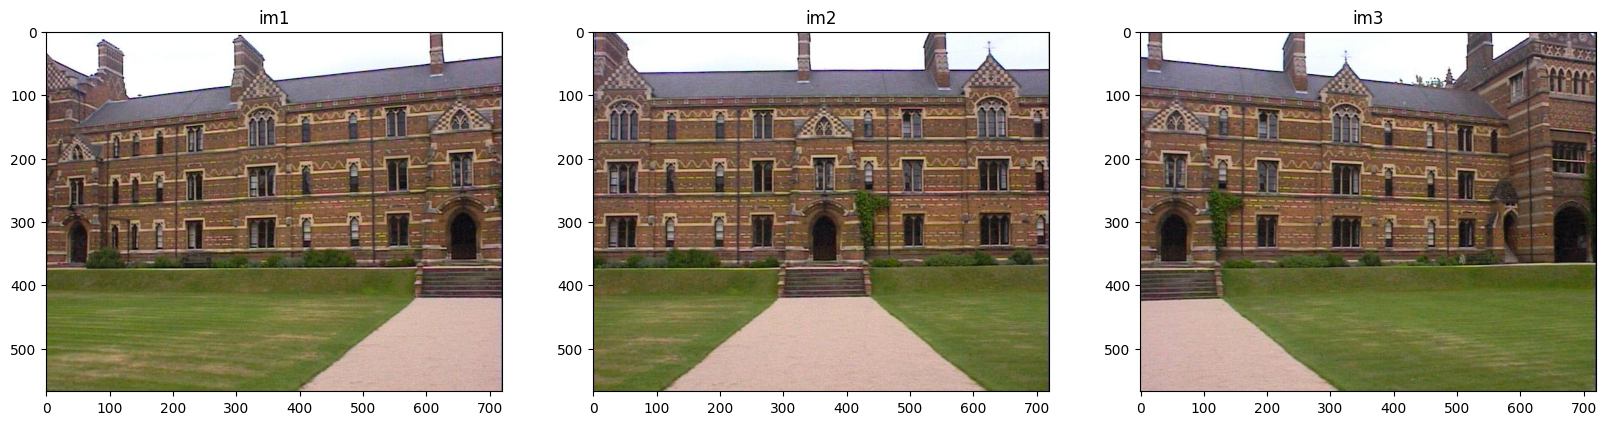

In [121]:
images = []
# fill in order of image taken
images.append(image.imread('data/keble_a.jpg'))
images.append(image.imread('data/keble_b.jpg'))
images.append(image.imread('data/keble_c.jpg'))

# plot images
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(images[0])
ax.set_title('im1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(images[1])
ax.set_title('im2')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(images[2])
ax.set_title('im3')
plt.show()

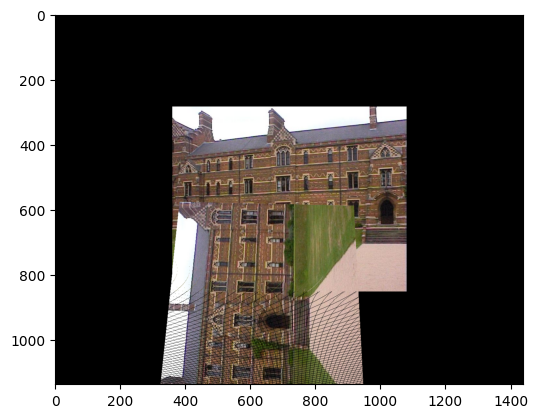

In [160]:
# src, dst = find_features_SIFT_between_images(im1, im2)

src = np.asarray([[0, 0], [0, 10], [10, 0], [10, 10]])
src_homo = np.asarray([[0, 0, 1], [0, 10, 1], [10, 0, 1], [10, 10, 1]])
dst = np.asarray([[1, 1], [1, 11], [11, 1], [11, 11]])

h = homoMatrix(src, dst)

def toHomogeneous2D(vec3):
    x = vec3[0]/vec3[2]
    y = vec3[1]/vec3[2]
    return x, y

"""
Colle l'image 2 sur l'image 1
"""
def warp(img1, img2):
    feature_points_im1, feature_points_im2 = find_features_ORB_between_images(img1, img2)
    hom, status = cv.findHomography(feature_points_im2, feature_points_im1, cv.RANSAC)
    #stitched_image = cv.warpPerspective(img2, hom, (2000, 2000))
    #return stitched_image
    h = np.asarray(hom)
    #h = np.linalg.inv(h)
    #h = homoMatrix(feature_points_im1, feature_points_im2)

    #Destination image twice as big as the source. Assumes the input images are
    #the same size
    stitched_image = np.zeros((img1.shape[0] * 2, img1.shape[1] * 2, 3), dtype=int)

    #Copies the first image into the destination
    x_start, y_start = int(0.5 * img1.shape[1]), int(0.5 * img1.shape[0])
    stitched_image[y_start:y_start + img1.shape[0], x_start:x_start + img1.shape[1]] = img1.copy()

    #Transforms the second image into the first image coordinates frame
    # Create a 2D grid of x, y coordinates
    x = np.arange(img2.shape[1])
    y = np.arange(img2.shape[0])

    # Use NumPy's meshgrid function to create coordinate grids
    xx, yy = np.meshgrid(x, y)
    zz = np.ones(xx.shape[0] * xx.shape[1])

    # Stack the coordinates to create a 1D array of (x, y) pairs
    coordinates = np.vstack((xx.ravel(), yy.ravel(), zz)).T
    #coordinates = np.asarray([[0, 0, 1], [1, 1, 1]])
    transformed_coordinates = coordinates.dot(h.T)
    transformed_coordinates = np.asarray([(int(a/c), int(b/c)) for (a, b, c) in transformed_coordinates])

    img2_width = img2.shape[1]
    for y in range(img2.shape[0]):
        for x in range(img2_width):
            transformed_y = transformed_coordinates[y * img2_width + x][0]
            transformed_x = transformed_coordinates[y * img2_width + x][1]

            destination_coord_x = transformed_x + x_start
            destination_coord_y = transformed_y + y_start

            if 0 < destination_coord_x < stitched_image.shape[1] and 0 < destination_coord_y < stitched_image.shape[0]:
                stitched_image[destination_coord_y, destination_coord_x] = img2[y, x]
    
    return stitched_image
"""

    width = imgSrc.shape[1]
    height = imgSrc.shape[0]

    lxt, lyt = toHomogeneous2D(np.dot(h, [[0],[0],[1]]))
    rxt, ryt = toHomogeneous2D(np.dot(h, [[width-1],[0],[1]]))
    lxb, lyb = toHomogeneous2D(np.dot(h, [[0],[height-1],[1]]))
    rxb, ryb = toHomogeneous2D(np.dot(h, [[width-1],[height-1],[1]]))


    # for y in range(min[1], max[1]):
    #     for x in range(min[0], max[0]):
    #         p = np.array([x, y, 1])
    #         p = np.dot(h_inv, p)
    #         p = p / p[2]
    #         if p[0] >= 0 and p[0] < imgSrc.shape[1] and p[1] >= 0 and p[1] < imgSrc.shape[0]:
    #             res[y, x] = imgSrc[int(p[1]), int(p[0])]
    #             #upscale factor
    # return res

    x_min = int(min(lxt, rxt, lxb, rxb))
    x_max = int(max(lxt, rxt, lxb, rxb))

    y_min = int(min(lyt, ryt, lyb, ryb))
    y_max = int(max(lyt, ryt, lyb, ryb))

    sx = x_max - x_min
    sy = y_max - y_min

    res = np.zeros((sy, sx, 3))

    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            p = ()
    """
    
"""
stitched_image = image[0]
n = len(images)
for i in range(1:n):
    if i<int(n/2):
        stitched_image = warp(stitched_image, images[i])
    else :
        stitched_image = warp(images[i], stitched_image)
"""


""""""
stitched_image = warp(images[0], images[1])

plt.imshow(stitched_image)



In [ ]:
find_features_FAST_and_BRIEF_between_images(images[0], images[1])

AttributeError: module 'cv2' has no attribute 'xfeatures2d'